In [53]:
import os
import numpy as np
import cv2

import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense


In [54]:
# test = True
test = False

The Brain tumor dataset is taken from `./brain_tumor_dataset/yes` and `brain_tumor_dataset/no` directories.

The dataset is divided into 2 directories: "yes" & "no". There are 253 images (155 images for "yes" and 98 images for "no").

first 190 yes images are for training for "yes" case and the reset

In [55]:
import os
import numpy as np

yes_imgs=os.listdir('./brain_tumor_dataset/yes')
no_imgs=os.listdir('./brain_tumor_dataset/no')

full_dataset=np.concatenate([yes_imgs,no_imgs])

In [56]:
if(test):
  print( full_dataset.size, full_dataset )

253 ['Y40.JPG' 'Y18.JPG' 'Y153.jpg' 'Y55.jpg' 'Y252.jpg' 'Y19.JPG' 'Y166.JPG'
 'Y97.JPG' 'Y182.JPG' 'Y92.jpg' 'Y183.jpg' 'Y36.JPG' 'Y12.jpg' 'Y44.JPG'
 'Y47.JPG' 'Y21.jpg' 'Y27.jpg' 'Y109.JPG' 'Y103.jpg' 'Y148.JPG' 'Y184.JPG'
 'Y54.jpg' 'Y52.jpg' 'Y70.jpg' 'Y22.jpg' 'Y98.JPG' 'Y34.jpg' 'Y106.jpg'
 'Y248.JPG' 'Y99.JPG' 'Y66.JPG' 'Y85.JPG' 'Y59.JPG' 'Y24.jpg' 'Y51.jpg'
 'Y105.jpg' 'Y81.jpg' 'Y170.JPG' 'Y41.jpg' 'Y250.jpg' 'Y161.JPG'
 'Y100.JPG' 'Y46.jpg' 'Y26.jpg' 'Y245.jpg' 'Y91.jpg' 'Y156.JPG' 'Y115.JPG'
 'Y120.JPG' 'Y10.jpg' 'Y188.jpg' 'Y6.jpg' 'Y243.JPG' 'Y101.jpg' 'Y165.JPG'
 'Y71.JPG' 'Y8.jpg' 'Y117.JPG' 'Y74.jpg' 'Y107.jpg' 'Y185.jpg' 'Y4.jpg'
 'Y14.jpg' 'Y23.JPG' 'Y9.jpg' 'Y244.JPG' 'Y102.jpg' 'Y95.jpg' 'Y168.jpg'
 'Y62.jpg' 'Y255.JPG' 'Y50.JPG' 'Y193.JPG' 'Y25.jpg' 'Y75.JPG' 'Y256.JPG'
 'Y13.jpg' 'Y146.JPG' 'Y31.jpg' 'Y112.JPG' 'Y69.jpg' 'Y45.JPG' 'Y247.JPG'
 'Y16.JPG' 'Y251.JPG' 'Y17.jpg' 'Y53.jpg' 'Y7.jpg' 'Y116.JPG' 'Y56.jpg'
 'Y195.JPG' 'Y30.jpg' 'Y33.jpg' 'Y246.JPG' 'Y1.jpg

The `resized_imgs` list contains the resized images of the `yes_imgs` and `no_imgs` lists.

In [57]:
import cv2

resized_imgs: list[cv2.Mat] = []
for img_file in yes_imgs:
    img = cv2.imread('./brain_tumor_dataset/yes/'+img_file)
    resized_img = cv2.resize(img, (32, 32))
    resized_imgs.append(resized_img)

for img_file in no_imgs:
    img = cv2.imread('./brain_tumor_dataset/no/'+img_file)
    resized_img = cv2.resize(img, (32, 32))
    resized_imgs.append(resized_img)


In [58]:
# # Displaying the first image in resized_imgs
if(test):
  cv2.imshow('image0', resized_imgs[0])
  cv2.waitKey(0)
  cv2.destroyAllWindows()

Convert the `resized_imgs` list to a numpy array and save it as `X`.

In [59]:
X = np.squeeze(resized_imgs)

In [60]:
if (test):
  print(type(X))
  print(X.shape)
  print(X)

<class 'numpy.ndarray'>
(253, 32, 32, 3)
[[[[ 33  33  33]
   [ 31  31  31]
   [ 29  29  29]
   ...
   [ 28  28  28]
   [ 28  28  28]
   [ 28  28  28]]

  [[ 32  32  32]
   [ 28  28  28]
   [ 19  19  19]
   ...
   [ 14  14  14]
   [ 14  14  14]
   [ 15  15  15]]

  [[ 31  31  31]
   [ 27  27  27]
   [ 20  20  20]
   ...
   [ 13  13  13]
   [ 14  14  14]
   [ 18  18  18]]

  ...

  [[ 31  31  31]
   [ 26  26  26]
   [ 17  14  16]
   ...
   [ 17  17  17]
   [ 17  17  17]
   [ 16  16  16]]

  [[ 32  32  32]
   [ 27  27  27]
   [ 34  31  33]
   ...
   [ 16  16  16]
   [ 17  17  17]
   [ 17  17  17]]

  [[ 32  32  32]
   [ 29  29  29]
   [ 32  31  33]
   ...
   [ 17  17  17]
   [ 18  18  18]
   [ 14  14  14]]]


 [[[  3   3   3]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [ 12  12  12]]

  [[  2   2   2]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [ 11  11  11]]

  [[  4   4   4]
   [  0   0   0]
   [  0   0   0]
   ...
   [

In [61]:
if (test):
  print(resized_imgs)

[array([[[33, 33, 33],
        [31, 31, 31],
        [29, 29, 29],
        ...,
        [28, 28, 28],
        [28, 28, 28],
        [28, 28, 28]],

       [[32, 32, 32],
        [28, 28, 28],
        [19, 19, 19],
        ...,
        [14, 14, 14],
        [14, 14, 14],
        [15, 15, 15]],

       [[31, 31, 31],
        [27, 27, 27],
        [20, 20, 20],
        ...,
        [13, 13, 13],
        [14, 14, 14],
        [18, 18, 18]],

       ...,

       [[31, 31, 31],
        [26, 26, 26],
        [17, 14, 16],
        ...,
        [17, 17, 17],
        [17, 17, 17],
        [16, 16, 16]],

       [[32, 32, 32],
        [27, 27, 27],
        [34, 31, 33],
        ...,
        [16, 16, 16],
        [17, 17, 17],
        [17, 17, 17]],

       [[32, 32, 32],
        [29, 29, 29],
        [32, 31, 33],
        ...,
        [17, 17, 17],
        [18, 18, 18],
        [14, 14, 14]]], dtype=uint8), array([[[  3,   3,   3],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
  

Normalize each pixel of the image present in the numpy array `X` and save it as `X`.

In [62]:

# normalize data
X = X.astype('float32')
X /= 255

In [63]:
if(test):
  print(X)

[[[[0.12941177 0.12941177 0.12941177]
   [0.12156863 0.12156863 0.12156863]
   [0.11372549 0.11372549 0.11372549]
   ...
   [0.10980392 0.10980392 0.10980392]
   [0.10980392 0.10980392 0.10980392]
   [0.10980392 0.10980392 0.10980392]]

  [[0.1254902  0.1254902  0.1254902 ]
   [0.10980392 0.10980392 0.10980392]
   [0.07450981 0.07450981 0.07450981]
   ...
   [0.05490196 0.05490196 0.05490196]
   [0.05490196 0.05490196 0.05490196]
   [0.05882353 0.05882353 0.05882353]]

  [[0.12156863 0.12156863 0.12156863]
   [0.10588235 0.10588235 0.10588235]
   [0.07843138 0.07843138 0.07843138]
   ...
   [0.05098039 0.05098039 0.05098039]
   [0.05490196 0.05490196 0.05490196]
   [0.07058824 0.07058824 0.07058824]]

  ...

  [[0.12156863 0.12156863 0.12156863]
   [0.10196079 0.10196079 0.10196079]
   [0.06666667 0.05490196 0.0627451 ]
   ...
   [0.06666667 0.06666667 0.06666667]
   [0.06666667 0.06666667 0.06666667]
   [0.0627451  0.0627451  0.0627451 ]]

  [[0.1254902  0.1254902  0.1254902 ]
   [0.1

The `img_labels` list stores the labels for each image. The labels are 0 for "no" and 1 for "yes".

In [64]:
labels_yes=np.full(len(yes_imgs),1)
labels_no=np.full(len(no_imgs),0)

img_labels=np.concatenate([labels_yes,labels_no])


In [65]:
if(test):
  print( img_labels.size, img_labels )

253 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [66]:
# from keras.utils.np_utils import to_categorical
# categorical_labels = to_categorical(img_labels, num_classes=2)
# categorical_labels


In [67]:
(x_train, y_train), (x_test, y_test) = (
    X[:190], img_labels[:190]), (X[190:], img_labels[190:])
(x_valid, y_valid) = (x_test[:63], y_test[:63])
#(x_test, y_test) = (x_test[63:], y_test[63:])


In [68]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=16,kernel_size=9, padding='same', activation='relu', input_shape=(32,32,3))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.45))

model.add(tf.keras.layers.Conv2D(filters=16,kernel_size=9,padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(filters=36, kernel_size=9, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.15))


model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# model summary
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 16)        3904      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 16, 16, 16)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 16)        20752     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 8, 8, 16)         0         
 g2D)                                                            
                                                                 
 dropout_33 (Dropout)        (None, 8, 8, 16)         

In [69]:
model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['acc'])

In [70]:
model.fit(x_train,
         y_train,
         batch_size=128,
         epochs=150,
         validation_data=(x_valid, y_valid),)

Epoch 1/150
2/2 [==============================] - 2s 552ms/step - loss: 0.6009 - acc: 0.6737 - val_loss: 1.3820 - val_acc: 0.0000e+00
Epoch 2/150
2/2 [==============================] - 1s 232ms/step - loss: 0.4496 - acc: 0.8158 - val_loss: 0.9335 - val_acc: 0.0000e+00
Epoch 3/150
2/2 [==============================] - 1s 252ms/step - loss: 0.4632 - acc: 0.8158 - val_loss: 1.1353 - val_acc: 0.0000e+00
Epoch 4/150
2/2 [==============================] - 0s 191ms/step - loss: 0.4601 - acc: 0.8158 - val_loss: 1.1355 - val_acc: 0.0000e+00
Epoch 5/150
2/2 [==============================] - 0s 206ms/step - loss: 0.4394 - acc: 0.8158 - val_loss: 0.9390 - val_acc: 0.0000e+00
Epoch 6/150
2/2 [==============================] - 0s 163ms/step - loss: 0.4566 - acc: 0.8158 - val_loss: 1.0029 - val_acc: 0.0000e+00
Epoch 7/150
2/2 [==============================] - 0s 156ms/step - loss: 0.4307 - acc: 0.8158 - val_loss: 1.1779 - val_acc: 0.0000e+00
Epoch 8/150
2/2 [==============================] - 0s 2

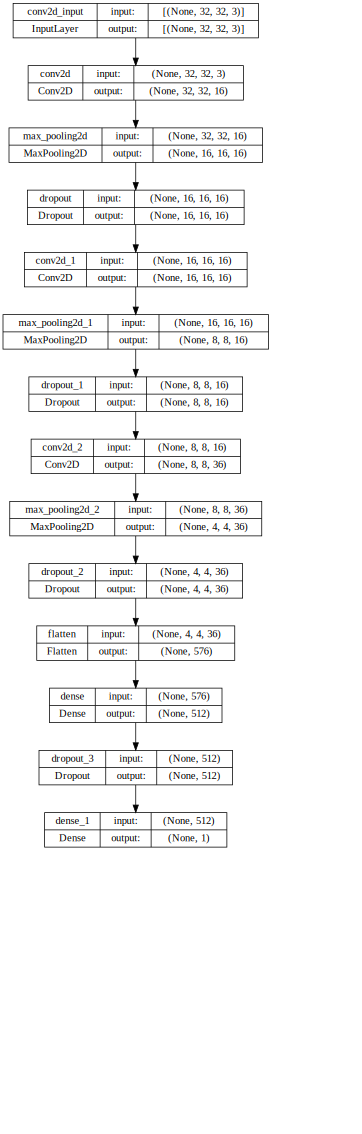

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes = True).create(prog='dot', format='svg'))

In [ ]:
# Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose="0")

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.682539701461792


In [ ]:
labels =["Yes", "No"]

2/2 [==============================] - 0s 13ms/step


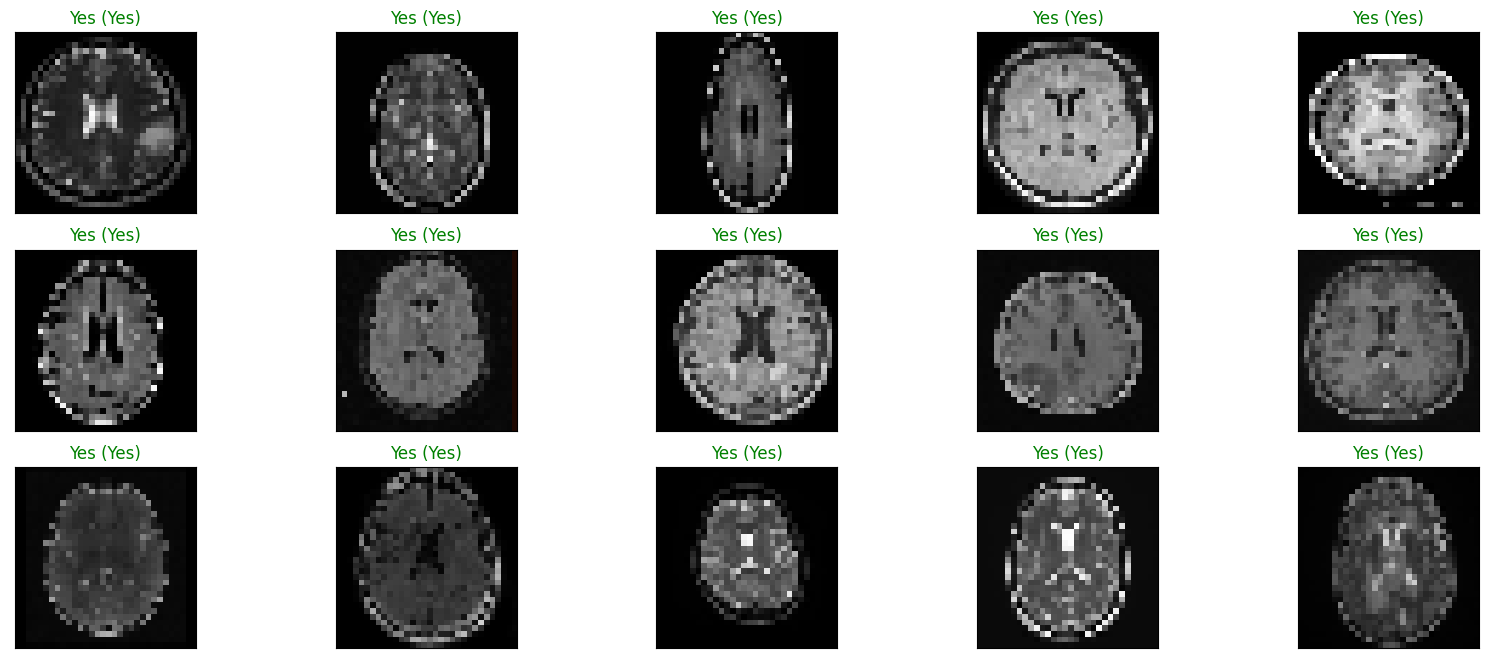

In [ ]:
test_set = x_test
y_hat = model.predict(test_set)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(test_set.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(test_set[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(labels[predict_index], 
                                  labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))
plt.show()